In [2]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta

#Plotting
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.ticker as ticker
from matplotlib import patches
from matplotlib.collections import LineCollection

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts
from physoce import oceans as oc

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Mapping tools
from cartopy.io import shapereader
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmocean import cm

#Custom function packages
import vector_tools as vt
import Plot_tools as pt

### Load Data

In [3]:
# ADCP data
adcp1 = xr.open_dataset('ADCP/adcp1_final.nc')
adcp2 = xr.open_dataset('ADCP/adcp2_final.nc')

# ADV data
adv1 = xr.open_dataset('ADV/adv1_final.nc')
adv2 = xr.open_dataset('ADV/adv2_final.nc')

# Temperature data
temp = xr.open_dataset('Temperature/temp_final.nc')

In [ ]:
tempDS = temp.copy(deep=True)

g=9.81
dz = .5 #Desired difference interval
binSize = adcpDS.attrs['Bin Size']

rhoInterp = temp.Rho.interp(bindist = bindistInterp, method = 'linear')

times = (adcpDS.time[0],adcpDS.time[-1])
rSamp='120Min'
offset='40Min'
Temp = tempDS.Temperature.sel(time=slice(E.time[0],E.time[-1]))
Temp = Temp.resample(time=rSamp,offset=offset).mean()
RhoInterp = tempDS.RhoInterp.sel(time=slice(E.time[0],E.time[-1]))
RhoInterp = RhoInterp.resample(time=rSamp,offset=offset).mean()[1:]
RhoBar = RhoInterp.mean(dim='bindistInterp').values

binStart = int(dz/binSize)
binEnd = int(len(RhoInterp.bindistInterp)-binStart)

E = E.where(E.time.isin(Temp.time),drop=True)[:binEnd+binStart]
N = N.where(N.time.isin(Temp.time),drop=True)[:binEnd+binStart]

theta, major, minor = ts.princax(E,N)
V,U = ts.rot(E,N,-theta-90)

dUdZ = ((-U[binStart:])-(-U[:-binStart]))/dz
dVdZ = ((V[binStart:])-(V[:-binStart]))/dz
dRdZ = (RhoInterp[binStart:].values-RhoInterp[:-binStart].values)/dz

cspd = np.sqrt(N**2+E**2)

S2 = (dUdZ**2)+(dVdZ**2)
N2 = dRdZ * (-g/RhoBar)
Ri = N2/S2

In [55]:
bindistInterp = np.arange(1,9,.25)
binSize=.25
g = 9.81 #Gravity


tempInterp = temp.Temperature.interp(bindist = bindistInterp, method = 'linear')
rhoInterp = temp.Rho.interp(bindist = bindistInterp, method = 'linear')
temp.coords['bindistInterp'] = bindistInterp
temp['tempInterp'] = (["bindistInterp", "time"], tempInterp.values, {'Description':'Linearly interpolated temperate over depth bins of ADCP','Units':'C'})
temp['RhoInterp'] = (["bindistInterp", "time"], rhoInterp.values, {'Description':'Linearly interpolated density over depth bins of ADCP','Units':'kg/m^3'})

RhoBar=temp.RhoInterp.mean().values
dRho = temp.RhoInterp[4:].values-temp.RhoInterp[:-4].values
N2 = dRho * (-g/RhoBar)

#Add 4 more rows of nan's to keep dimensions consistent with bindistInterp
# Existing 2D array
existing_arraydRho = dRho
existing_arrayN2 = N2

# Number of rows to add
num_rows_to_add = 4

# Number of columns in the existing array
num_columns = existing_arrayN2.shape[1]

# Create an array of NaN values with the same number of columns
nan_values = np.full((num_rows_to_add, num_columns), np.nan)

# Concatenate the existing array and the array with NaN values
dRho_new = np.concatenate((existing_arraydRho, nan_values), axis=0)
N2_new = np.concatenate((existing_arrayN2, nan_values), axis=0)

temp['dRho'] = (['bindistInterp','time'],dRho_new)
temp['dRho'].attrs['Description'] = 'Change in density with depth'

temp['N2'] = (['bindistInterp','time'],N2_new)
temp['N2'].attrs['Description'] = 'Buoyancy (Brunt-Väisälä) frequency squared'
temp['N2'].attrs['Units'] = r'$\frac{1}{s^{2}}$'

In [56]:
temp

<xarray.Dataset>
Dimensions:        (depth: 7, bindist: 7, time: 69761, bindistInterp: 32)
Coordinates:
  * depth          (depth) float64 2.0 4.0 6.0 8.0 9.25 9.5 9.75
  * bindist        (bindist) float64 8.75 6.75 4.75 2.75 1.5 1.25 1.0
  * time           (time) datetime64[ns] 2022-07-21T22:39:00 ... 2022-09-08T1...
  * bindistInterp  (bindistInterp) float64 1.0 1.25 1.5 1.75 ... 8.25 8.5 8.75
Data variables:
    Temperature    (bindist, time) float64 ...
    Rho            (bindist, time) float64 ...
    TemperatureDA  (time) float64 ...
    RhoDA          (time) float64 ...
    tempInterp     (bindistInterp, time) float64 10.91 10.91 ... 13.16 13.19
    RhoInterp      (bindistInterp, time) float64 1.026e+03 ... 1.025e+03
    dRho           (bindistInterp, time) float64 -0.008427 -0.008427 ... nan nan
    N2             (bindistInterp, time) float64 8.063e-05 8.063e-05 ... nan nan
Attributes: (12/13)
    description:           Temperature of water column over time
    Description:           Temperature and density profiles of Stillwater Cove
    Creator:               Logan Grady
    Contact information:   loganagrady@gmail.com
    Instrument:            HOBO Temperature Logger Pro V2
    Sampling rate:         1Min
    ...                    ...
    Latitude:              36.56196
    Longitude:             -121.94176
    Deployment:            2022-07-21T22:39:00.000000000
    Retrieval:             2022-09-08T10:33:00.000000000
    Depths from surface:   ['2m', '4m', '6m', '8m', '9.25m', '9.5m', '9.75m']
    Height from seafloor:  ['8.75m', '6.75m', '4.75m', '2.75m', '1.5m', '1.25...

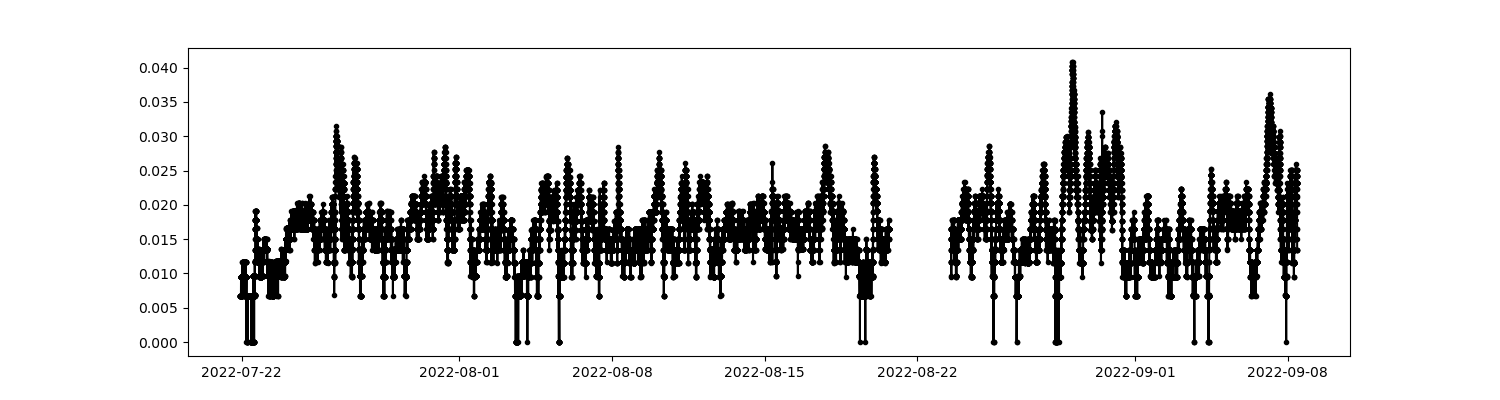

In [53]:
plt.figure(figsize=(15,4))
plt.plot(temp.time,np.sqrt(temp.N2[2]),'.-k')

In [58]:
temp.to_netcdf('Temperature/temp_final2.nc')

# Deployment 1

In [4]:
adcpDS = adcp1.copy(deep=True)
tempDS = temp.copy(deep=True)

g=9.81
dz = 1 #Desired difference interval
binSize = adcpDS.attrs['Bin Size']

times = (adcpDS.time[0],adcpDS.time[-1])
rSamp='60Min'
offset='40Min'
    
E = adcpDS.East.sel(time=slice(times[0],times[1]))
E = E.resample(time=rSamp,offset=offset).mean().dropna(dim='time',how='all')
N = adcpDS.North.sel(time=slice(times[0],times[1]))
N = N.resample(time=rSamp,offset=offset).mean().dropna(dim='time',how='all')

Temp = tempDS.Temperature.sel(time=slice(E.time[0],E.time[-1]))
Temp = Temp.resample(time=rSamp,offset=offset).mean()
RhoInterp = tempDS.RhoInterp.sel(time=slice(E.time[0],E.time[-1]))
RhoInterp = RhoInterp.resample(time=rSamp,offset=offset).mean()[1:]
RhoBar = RhoInterp.mean(dim='bindistInterp').values

binStart = int(dz/binSize)
binEnd = int(len(RhoInterp.bindistInterp)-binStart)

E = E.where(E.time.isin(Temp.time),drop=True)[:binEnd+binStart]
N = N.where(N.time.isin(Temp.time),drop=True)[:binEnd+binStart]

theta, major, minor = ts.princax(E,N)
V,U = ts.rot(E,N,-theta-90)

dUdZ = ((-U[binStart:])-(-U[:-binStart]))/dz
dVdZ = ((V[binStart:])-(V[:-binStart]))/dz
dRdZ = (RhoInterp[binStart:].values-RhoInterp[:-binStart].values)/dz

cspd = np.sqrt(N**2+E**2)

S2 = (dUdZ**2)+(dVdZ**2)
N2 = dRdZ * (-g/RhoBar)
Ri = N2/S2

RiDS1 = xr.Dataset(
            data_vars=dict(
                East = (["bindist", "time"], E.values, {'Description':'Eastern velocity','Units':'m/s'}),
                North = (["bindist", "time"], N.values, {'Description':'Northern velocity','Units':'m/s'}),
                U = (["bindist", "time"], -U, {'Description':'Along-bay ADCP velocity','Units':'m/s'}),
                V = (["bindist", "time"], V, {'Description':'Across-bay ADCP velocity','Units':'m/s'}),
                CSPD = (["bindist", "time"],cspd.values, {'Description':'Horizontal current speed','Units':'m/s'}),
                Rho = (["bindist", "time"], RhoInterp.values, {'Description':'Linearly interpolated density over depth bins of ADCP','Units':'kg/m^3'}),
                RhoBar = (["time"], RhoBar, {'Description':'Mean density of segment time','Units':'kg/m^3'}),
                dUdZ = (["bindistShifted","time"], dUdZ, {'Description':'Change in U over specific dz','Units':r'm/$s^{2}$'}),
                dVdZ = (["bindistShifted","time"], dVdZ, {'Description':'Change in V over specific dz','Units':r'm/$s^{2}$'}),
                dRdZ = (["bindistShifted","time"], dVdZ, {'Description':'Change in density over specific dz','Units':r'kg/$m^{4}$'}),
                S2 = (["bindistShifted","time"], S2, {'Description':'Shear squared','Units':r'$\frac{1}{s^{2}}$'}),
                N2 = (["bindistShifted","time"], N2, {'Description':'Buoyancy (Brunt-Väisälä) frequency squared','Units':r'$\frac{rad}{s^{2}}$'}),
                Ri = (["bindistShifted","time"], Ri, {'Description':'Gradient Richardson number'}),
            ),
            coords=dict(
                bindist = (["bindist"],E.bindist.data),
                bindistShifted = (["bindistShifted"], E.bindist[:-binStart].data),
                time=(["time"], E.time.data),
            ),
            attrs=dict(
                Description = "All data and products used for calculating the gradient Richardson number",
                BinSize = binSize,
                BinInterval_m = dz,
                Resample = rSamp,
                Offset = offset,
                PrincipleAxisAngle = -theta-90,
            ),
                
        )

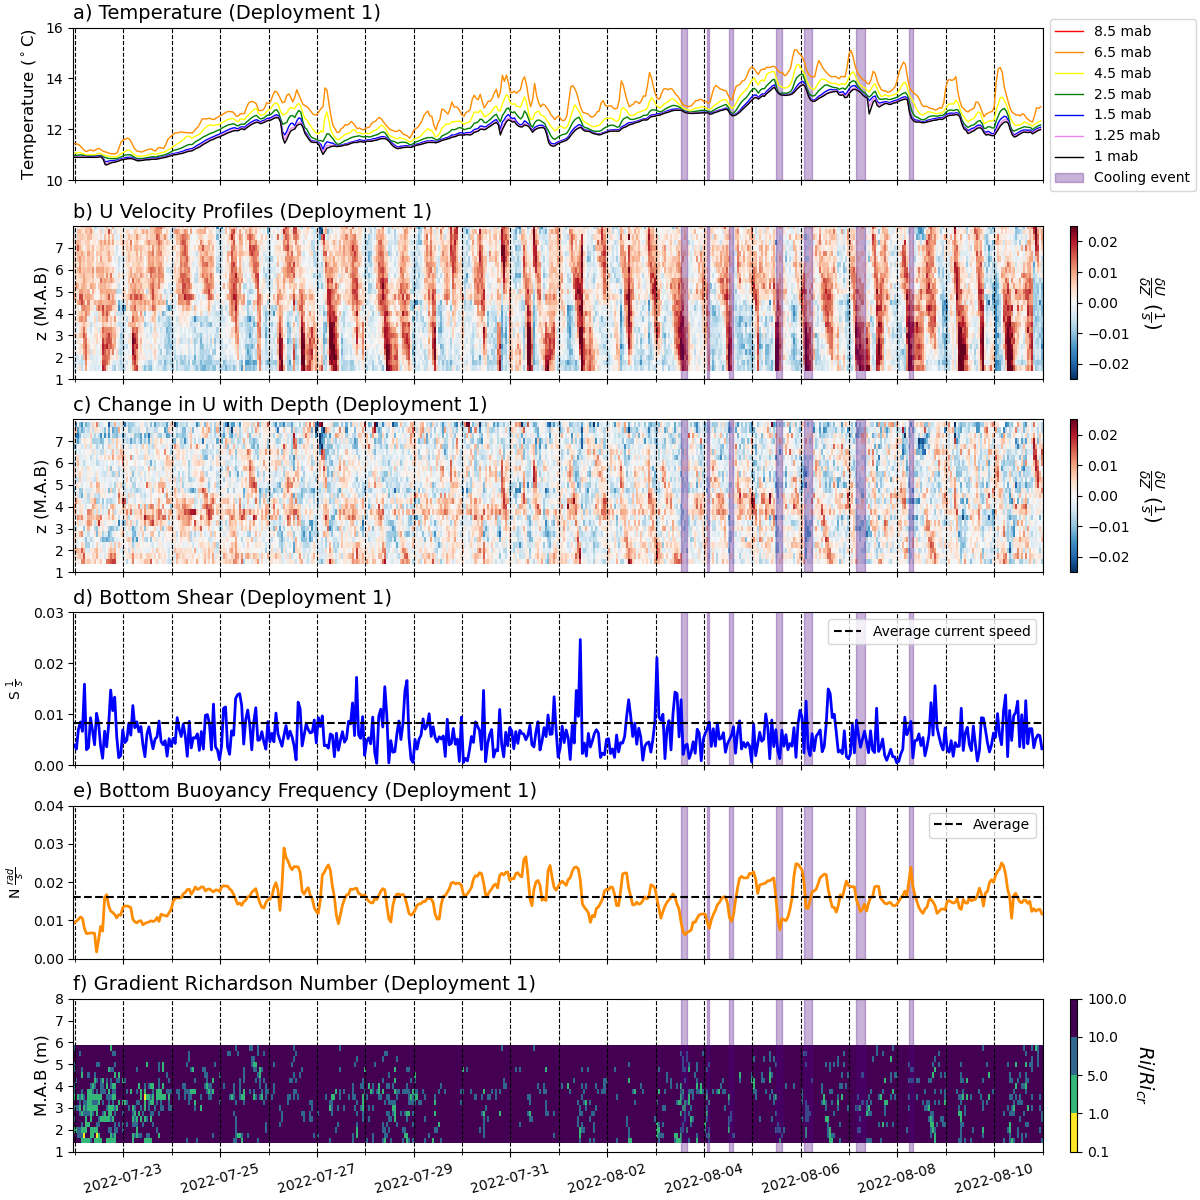

In [5]:
RiDS = RiDS1.copy(deep=True)
tempDS = temp.copy(deep=True)

Temp = tempDS.Temperature.sel(time=slice(RiDS.time[0],RiDS.time[-1]))
Temp = Temp.resample(time = '60Min').mean()

ceTimes1 = (('2022-08-03T12:40:00.000000000','2022-08-03T13:40:00.000000000', '2022-08-03T14:40:00.000000000','2022-08-03T15:40:00.000000000',
             '2022-08-04T01:40:00.000000000','2022-08-04T02:40:00.000000000', 
             '2022-08-04T12:40:00.000000000','2022-08-04T13:40:00.000000000', '2022-08-04T14:40:00.000000000',
             '2022-08-05T11:40:00.000000000', '2022-08-05T12:40:00.000000000','2022-08-05T13:40:00.000000000', '2022-08-05T14:40:00.000000000',
             '2022-08-06T01:40:00.000000000', '2022-08-06T02:40:00.000000000','2022-08-06T03:40:00.000000000', '2022-08-06T04:40:00.000000000','2022-08-06T05:40:00.000000000',
             '2022-08-07T03:40:00.000000000','2022-08-07T04:40:00.000000000', '2022-08-07T05:40:00.000000000','2022-08-07T06:40:00.000000000', '2022-08-07T07:40:00.000000000',
             '2022-08-08T05:40:00.000000000','2022-08-08T06:40:00.000000000', '2022-08-08T07:40:00.000000000'))
ceTimes1 = np.array(ceTimes1,dtype='datetime64[ns]')
timeDiff = np.diff(ceTimes1,prepend=ceTimes1[0]).astype(dtype='timedelta64[h]').astype(dtype=int)
ceTimesSplit = np.split(ceTimes1,np.where(timeDiff>1)[0])

fig,axs=plt.subplots(6,1,constrained_layout=True,sharex=True,figsize=(12,12))

axs[0].set_title('a) Temperature (Deployment 1)', loc='left', size=14) 
axs[0].set_prop_cycle(c = ['red','darkorange','yellow','green','blue','violet','black'])
axs[0].plot(Temp.time, Temp.T, lw = 1)
axs[0].set_ylabel(r'Temperature ($^\circ$C)', fontsize=12)
axs[0].margins(x=.01)
axs[0].set_ylim(10,16)
axs[0].grid(ls='--',color='black',axis='x',which='both')
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[0].fill_between([i[1][0], i[1][-1]], 10, 16, color='indigo', alpha=0.3)
axs[0].legend(labels=['8.5 mab','6.5 mab','4.5 mab','2.5 mab','1.5 mab','1.25 mab','1 mab','Cooling event'], bbox_to_anchor=(1, 1.1), loc="upper left", fancybox=True, fontsize=10)

axs[1].set_title('b) U Velocity Profiles (Deployment 1)', loc='left', size=14) 
UPlot = axs[1].pcolormesh(RiDS.time, RiDS.bindist[1:], RiDS.U[1:], vmin=-.025,vmax=.025, cmap = 'RdBu_r', shading = 'nearest')
axs[1].set_ylabel('z (M.A.B)', fontsize = 12)
axs[1].yaxis.set_major_locator(ticker.FixedLocator(np.arange(-1,8,1)))
axs[1].tick_params(axis = 'x', labelrotation = 25)
axs[1].set_ylim(1,8)
fig.colorbar(UPlot, location='right',pad=-.13).set_label(label=r"$\frac{\delta U}{\delta Z}$ ($\frac{1}{s}$)",size=14,rotation = -90, va = 'bottom')
axs[1].grid(axis='x',ls='--',c='black',which='both')
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[1].fill_between([i[1][0], i[1][-1]], 1, 8, color='indigo', alpha=0.3)
        
axs[2].set_title('c) Change in U with Depth (Deployment 1)', loc='left', size=14) 
dUPlot = axs[2].pcolormesh(RiDS.time, RiDS.bindistShifted[1:], RiDS.dUdZ[1:], vmin=-.025,vmax=.025, cmap = 'RdBu_r', shading = 'nearest')
axs[2].set_ylabel('z (M.A.B)', fontsize = 12)
axs[2].yaxis.set_major_locator(ticker.FixedLocator(np.arange(-1,8,1)))
axs[2].tick_params(axis = 'x', labelrotation = 25)
axs[2].set_ylim(1,8)
fig.colorbar(dUPlot, location='right',pad=-.13).set_label(label=r"$\frac{\delta U}{\delta Z}$ ($\frac{1}{s}$)",size=14,rotation = -90, va = 'bottom')
axs[2].grid(axis='x',ls='--',c='black',which='both')
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[2].fill_between([i[1][0], i[1][-1]], 1, 8, color='indigo', alpha=0.3)

axs[3].set_title('d) Bottom Shear (Deployment 1)', loc='left', size=14) 
axs[3].plot(RiDS.time,np.sqrt(RiDS.S2[2]),'-b',lw=2)
axs[3].set_ylabel(r'S $\frac{1}{s}$')
axs[3].axhline(y=RiDS.CSPD[1].mean(),ls='--',color='black',label = 'Average current speed')
axs[3].grid(axis='x',ls='--',c='black',which='both')
axs[3].set_ylim(0,.03)
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[3].fill_between([i[1][0], i[1][-1]], 0, .04, color='indigo', alpha=0.3)
axs[3].legend(fontsize=10)

axs[4].set_title('e) Bottom Buoyancy Frequency (Deployment 1)', loc='left', size=14) 
axs[4].plot(RiDS.time,np.sqrt(RiDS.N2[2]),'-',lw=2,c='darkorange')
axs[4].set_ylabel(r'N $\frac{rad}{s}$')
axs[4].axhline(y=np.sqrt(RiDS.N2[1]).mean(),ls='--',color='black',label = 'Average')
axs[4].grid(axis='x',ls='--',c='black',which='both')
axs[4].set_ylim(0,.04)
#axs[3].set_yscale('log')
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[4].fill_between([i[1][0], i[1][-1]], 0, .04, color='indigo', alpha=0.3)
axs[4].legend(fontsize=10)

bounds = np.array([.1, 1, 5, 10, 100])
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
axs[5].set_title('f) Gradient Richardson Number (Deployment 1)', loc='left', size=14)
RiPlot = axs[5].pcolormesh(RiDS.time, RiDS.bindistShifted[1:], RiDS.Ri[1:]/.25, norm = norm, cmap = 'viridis_r', shading = 'nearest')
axs[5].set_ylabel('M.A.B (m)', fontsize = 12)
axs[5].yaxis.set_major_locator(ticker.FixedLocator(np.arange(-1,9,1)))
axs[5].xaxis.set_major_locator(mdates.DayLocator(interval=2))
axs[5].xaxis.set_minor_locator(mdates.DayLocator(interval=1))
axs[5].tick_params(axis = 'x', labelrotation = 15)
axs[5].set_ylim(1,8)
fig.colorbar(RiPlot, location='right',pad=-.13).set_label(label=r"$Ri/Ri_{cr}$",size=14,rotation = -90, va = 'bottom')
axs[5].grid(axis='x',which='both', ls='--',c='black')
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[5].fill_between([i[1][0], i[1][-1]], 1, 8, color='indigo', alpha=0.3)

# Deployment 2

In [6]:
adcpDS = adcp2.copy(deep=True)
tempDS = temp.copy(deep=True)

g=9.81
dz = 1 #Desired difference interval
binSize = adcpDS.attrs['Bin Size']

times = (adcpDS.time[0],adcpDS.time[-1])
rSamp='60Min'
offset='40Min'
    
E = adcpDS.East.sel(time=slice(times[0],times[1]))
E = E.resample(time=rSamp,offset=offset).mean().dropna(dim='time',how='all')
N = adcpDS.North.sel(time=slice(times[0],times[1]))
N = N.resample(time=rSamp,offset=offset).mean().dropna(dim='time',how='all')

Temp = tempDS.Temperature.sel(time=slice(E.time[0],E.time[-1]))
Temp = Temp.resample(time=rSamp,offset=offset).mean()
RhoInterp = tempDS.RhoInterp.sel(time=slice(E.time[0],E.time[-1]))
RhoInterp = RhoInterp.resample(time=rSamp,offset=offset).mean()[1:]
RhoBar = RhoInterp.mean(dim='bindistInterp').values

binStart = int(dz/binSize)
binEnd = int(len(RhoInterp.bindistInterp)-binStart)

E = E.where(E.time.isin(Temp.time),drop=True)[:binEnd+binStart]
N = N.where(N.time.isin(Temp.time),drop=True)[:binEnd+binStart]

theta, major, minor = ts.princax(E,N)
V,U = ts.rot(E,N,-theta-90)

dUdZ = ((-U[binStart:])-(-U[:-binStart]))/dz
dVdZ = ((V[binStart:])-(V[:-binStart]))/dz
dRdZ = (RhoInterp[binStart:].values-RhoInterp[:-binStart].values)/dz

cspd = np.sqrt(N**2+E**2)

S2 = (dUdZ**2)+(dVdZ**2)
N2 = dRdZ * (-g/RhoBar)
Ri = N2/S2

RiDS2 = xr.Dataset(
            data_vars=dict(
                East = (["bindist", "time"], E.values, {'Description':'Eastern velocity','Units':'m/s'}),
                North = (["bindist", "time"], N.values, {'Description':'Northern velocity','Units':'m/s'}),
                U = (["bindist", "time"], -U, {'Description':'Along-bay ADCP velocity','Units':'m/s'}),
                V = (["bindist", "time"], V, {'Description':'Across-bay ADCP velocity','Units':'m/s'}),
                CSPD = (["bindist", "time"],cspd.values, {'Description':'Horizontal current speed','Units':'m/s'}),
                Rho = (["bindist", "time"], RhoInterp.values, {'Description':'Linearly interpolated density over depth bins of ADCP','Units':'kg/m^3'}),
                RhoBar = (["time"], RhoBar, {'Description':'Mean density of segment time','Units':'kg/m^3'}),
                dUdZ = (["bindistShifted","time"], dUdZ, {'Description':'Change in U over specific dz','Units':r'm/$s^{2}$'}),
                dVdZ = (["bindistShifted","time"], dVdZ, {'Description':'Change in V over specific dz','Units':r'm/$s^{2}$'}),
                dRdZ = (["bindistShifted","time"], dVdZ, {'Description':'Change in density over specific dz','Units':r'kg/$m^{4}$'}),
                S2 = (["bindistShifted","time"], S2, {'Description':'Shear squared','Units':r'$\frac{1}{s^{2}}$'}),
                N2 = (["bindistShifted","time"], N2, {'Description':'Buoyancy (Brunt-Väisälä) frequency squared','Units':r'$\frac{rad}{s^{2}}$'}),
                Ri = (["bindistShifted","time"], Ri, {'Description':'Gradient Richardson number'}),
            ),
            coords=dict(
                bindist = (["bindist"],E.bindist.data),
                bindistShifted = (["bindistShifted"], E.bindist[:-binStart].data),
                time=(["time"], E.time.data),
            ),
            attrs=dict(
                Description = "All data and products used for calculating the gradient Richardson number",
                BinSize = binSize,
                BinInterval_m = dz,
                Resample = rSamp,
                Offset = offset,
                PrincipleAxisAngle = -theta-90,
            ),
                
        )

In [10]:
RiDS2

<xarray.Dataset>
Dimensions:         (bindist: 31, time: 168, bindistShifted: 27)
Coordinates:
  * bindist         (bindist) float64 1.25 1.5 1.75 2.0 ... 8.0 8.25 8.5 8.75
  * bindistShifted  (bindistShifted) float64 1.25 1.5 1.75 2.0 ... 7.25 7.5 7.75
  * time            (time) datetime64[ns] 2022-08-23T11:40:00 ... 2022-08-30T...
Data variables: (12/13)
    East            (bindist, time) float64 0.01645 0.01096 ... -0.01119
    North           (bindist, time) float64 0.0001514 -0.002245 ... -0.008544
    U               (bindist, time) float64 0.01367 0.00779 ... -0.01406
    V               (bindist, time) float64 -0.00915 -0.008036 ... -0.0007498
    CSPD            (bindist, time) float64 0.01645 0.01119 ... 0.01278 0.01408
    Rho             (bindist, time) float64 nan 1.025e+03 ... 1.025e+03
    ...              ...
    dUdZ            (bindistShifted, time) float64 -0.002684 ... -0.006884
    dVdZ            (bindistShifted, time) float64 0.007069 ... 0.007507
    dRdZ            (bindistShifted, time) float64 0.007069 ... 0.007507
    S2              (bindistShifted, time) float64 5.718e-05 ... 0.0001037
    N2              (bindistShifted, time) float64 nan 0.0002101 ... 0.0002797
    Ri              (bindistShifted, time) float64 nan 3.201 ... 29.52 2.696
Attributes:
    Description:         All data and products used for calculating the gradi...
    BinSize:             0.25
    BinInterval_m:       1
    Resample:            60Min
    Offset:              40Min
    PrincipleAxisAngle:  -124.31783501402998

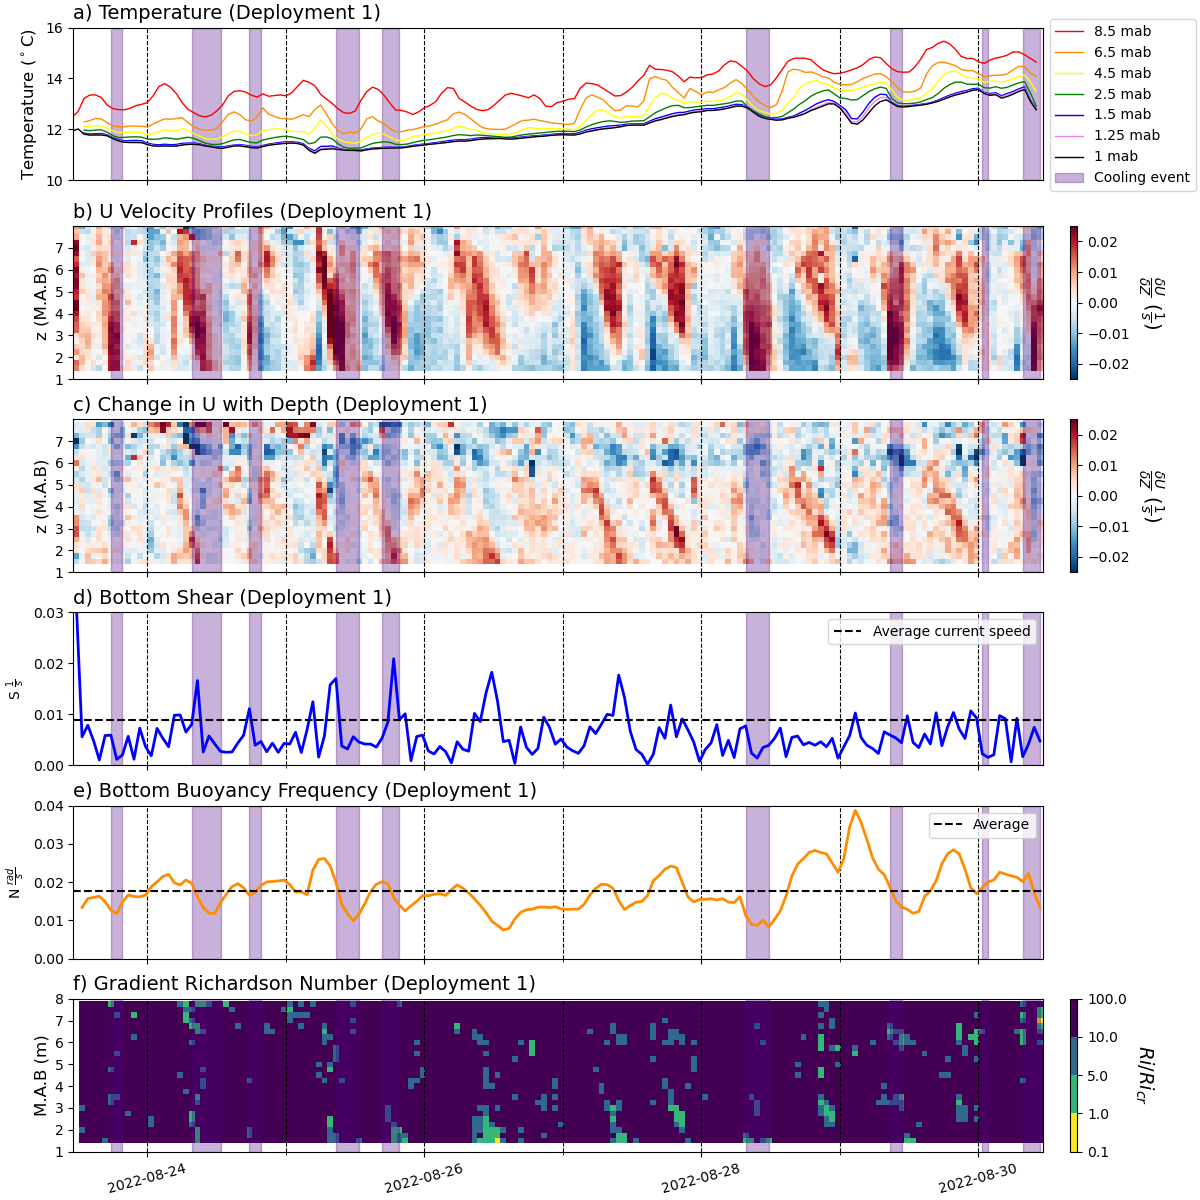

In [11]:
RiDS = RiDS2.copy(deep=True)
tempDS = temp.copy(deep=True)

Temp = tempDS.Temperature.sel(time=slice(RiDS.time[0],RiDS.time[-1]))
Temp = Temp.resample(time = '60Min').mean()
ceTimes1 = (('2022-08-23T17:40:00.000000000','2022-08-23T18:40:00.000000000','2022-08-23T19:40:00.000000000',
             '2022-08-24T07:40:00.000000000','2022-08-24T08:40:00.000000000','2022-08-24T09:40:00.000000000','2022-08-24T10:40:00.000000000','2022-08-24T11:40:00.000000000','2022-08-24T12:40:00.000000000',
             '2022-08-24T17:40:00.000000000','2022-08-24T18:40:00.000000000','2022-08-24T19:40:00.000000000',
             '2022-08-25T08:40:00.000000000','2022-08-25T09:40:00.000000000','2022-08-25T10:40:00.000000000','2022-08-25T11:40:00.000000000','2022-08-25T12:40:00.000000000',
             '2022-08-25T16:40:00.000000000','2022-08-25T17:40:00.000000000','2022-08-25T18:40:00.000000000','2022-08-25T19:40:00.000000000',
             '2022-08-28T07:40:00.000000000','2022-08-28T08:40:00.000000000','2022-08-28T09:40:00.000000000','2022-08-28T10:40:00.000000000','2022-08-28T11:40:00.000000000',
             '2022-08-29T08:40:00.000000000','2022-08-29T09:40:00.000000000','2022-08-29T10:40:00.000000000',
             '2022-08-30T00:40:00.000000000','2022-08-30T01:40:00.000000000',
             '2022-08-30T07:40:00.000000000', '2022-08-30T08:40:00.000000000','2022-08-30T09:40:00.000000000','2022-08-30T10:40:00.000000000'))
ceTimes1 = np.array(ceTimes1,dtype='datetime64[ns]')
timeDiff = np.diff(ceTimes1,prepend=ceTimes1[0]).astype(dtype='timedelta64[h]').astype(dtype=int)
ceTimesSplit = np.split(ceTimes1,np.where(timeDiff>1)[0])

fig,axs=plt.subplots(6,1,constrained_layout=True,sharex=True,figsize=(12,12))

axs[0].set_title('a) Temperature (Deployment 1)', loc='left', size=14) 
axs[0].set_prop_cycle(c = ['red','darkorange','yellow','green','blue','violet','black'])
axs[0].plot(Temp.time, Temp.T, lw = 1)
axs[0].set_ylabel(r'Temperature ($^\circ$C)', fontsize=12)
axs[0].margins(x=.01)
axs[0].set_ylim(10,16)
axs[0].grid(ls='--',color='black',axis='x',which='both')
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[0].fill_between([i[1][0], i[1][-1]], 10, 16, color='indigo', alpha=0.3)
axs[0].legend(labels=['8.5 mab','6.5 mab','4.5 mab','2.5 mab','1.5 mab','1.25 mab','1 mab','Cooling event'], bbox_to_anchor=(1, 1.1), loc="upper left", fancybox=True, fontsize=10)

axs[1].set_title('b) U Velocity Profiles (Deployment 1)', loc='left', size=14) 
UPlot = axs[1].pcolormesh(RiDS.time, RiDS.bindist[1:], RiDS.U[1:], vmin=-.025,vmax=.025, cmap = 'RdBu_r', shading = 'nearest')
axs[1].set_ylabel('z (M.A.B)', fontsize = 12)
axs[1].yaxis.set_major_locator(ticker.FixedLocator(np.arange(-1,8,1)))
axs[1].tick_params(axis = 'x', labelrotation = 25)
axs[1].set_ylim(1,8)
fig.colorbar(UPlot, location='right',pad=-.13).set_label(label=r"$\frac{\delta U}{\delta Z}$ ($\frac{1}{s}$)",size=14,rotation = -90, va = 'bottom')
axs[1].grid(axis='x',ls='--',c='black',which='both')
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[1].fill_between([i[1][0], i[1][-1]], 1, 8, color='indigo', alpha=0.3)
        
axs[2].set_title('c) Change in U with Depth (Deployment 1)', loc='left', size=14) 
dUPlot = axs[2].pcolormesh(RiDS.time, RiDS.bindistShifted[1:], RiDS.dUdZ[1:], vmin=-.025,vmax=.025, cmap = 'RdBu_r', shading = 'nearest')
axs[2].set_ylabel('z (M.A.B)', fontsize = 12)
axs[2].yaxis.set_major_locator(ticker.FixedLocator(np.arange(-1,8,1)))
axs[2].tick_params(axis = 'x', labelrotation = 25)
axs[2].set_ylim(1,8)
fig.colorbar(dUPlot, location='right',pad=-.13).set_label(label=r"$\frac{\delta U}{\delta Z}$ ($\frac{1}{s}$)",size=14,rotation = -90, va = 'bottom')
axs[2].grid(axis='x',ls='--',c='black',which='both')
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[2].fill_between([i[1][0], i[1][-1]], 1, 8, color='indigo', alpha=0.3)

axs[3].set_title('d) Bottom Shear (Deployment 1)', loc='left', size=14) 
axs[3].plot(RiDS.time,np.sqrt(RiDS.S2[2]),'-b',lw=2)
axs[3].set_ylabel(r'S $\frac{1}{s}$')
axs[3].axhline(y=RiDS.CSPD[1].mean(),ls='--',color='black',label = 'Average current speed')
axs[3].grid(axis='x',ls='--',c='black',which='both')
axs[3].set_ylim(0,.03)
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[3].fill_between([i[1][0], i[1][-1]], 0, .04, color='indigo', alpha=0.3)
axs[3].legend(fontsize=10)

axs[4].set_title('e) Bottom Buoyancy Frequency (Deployment 1)', loc='left', size=14) 
axs[4].plot(RiDS.time,np.sqrt(RiDS.N2[2]),'-',lw=2,c='darkorange')
axs[4].set_ylabel(r'N $\frac{rad}{s}$')
axs[4].axhline(y=np.sqrt(RiDS.N2[1]).mean(),ls='--',color='black',label = 'Average')
axs[4].grid(axis='x',ls='--',c='black',which='both')
axs[4].set_ylim(0,.04)
#axs[3].set_yscale('log')
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[4].fill_between([i[1][0], i[1][-1]], 0, .04, color='indigo', alpha=0.3)
axs[4].legend(fontsize=10)

bounds = np.array([.1, 1, 5, 10, 100])
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
axs[5].set_title('f) Gradient Richardson Number (Deployment 1)', loc='left', size=14)
RiPlot = axs[5].pcolormesh(RiDS.time, RiDS.bindistShifted[1:], RiDS.Ri[1:]/.25, norm = norm, cmap = 'viridis_r', shading = 'nearest')
axs[5].set_ylabel('M.A.B (m)', fontsize = 12)
axs[5].yaxis.set_major_locator(ticker.FixedLocator(np.arange(-1,9,1)))
axs[5].xaxis.set_major_locator(mdates.DayLocator(interval=2))
axs[5].xaxis.set_minor_locator(mdates.DayLocator(interval=1))
axs[5].tick_params(axis = 'x', labelrotation = 15)
axs[5].set_ylim(1,8)
fig.colorbar(RiPlot, location='right',pad=-.13).set_label(label=r"$Ri/Ri_{cr}$",size=14,rotation = -90, va = 'bottom')
axs[5].grid(axis='x',which='both', ls='--',c='black')
for i in enumerate(ceTimesSplit):
    if len(i[1])>=2:
        axs[5].fill_between([i[1][0], i[1][-1]], 1, 8, color='indigo', alpha=0.3)

In [58]:
RiDS1

<xarray.Dataset>
Dimensions:         (bindist: 31, time: 241, bindistShifted: 29)
Coordinates:
  * bindist         (bindist) float64 1.25 1.5 1.75 2.0 ... 8.0 8.25 8.5 8.75
  * bindistShifted  (bindistShifted) float64 1.25 1.5 1.75 2.0 ... 7.75 8.0 8.25
  * time            (time) datetime64[ns] 2022-07-21T22:40:00 ... 2022-08-10T...
Data variables: (12/13)
    East            (bindist, time) float64 -0.01495 -0.009333 ... 0.00028
    North           (bindist, time) float64 -0.0051 -0.0001 ... 0.006427
    U               (bindist, time) float64 -0.0157 -0.008499 ... 0.002974
    V               (bindist, time) float64 0.001706 0.003859 ... 0.005704
    CSPD            (bindist, time) float64 0.0158 0.009334 ... 0.01193 0.006433
    Rho             (bindist, time) float64 1.026e+03 1.026e+03 ... nan nan
    ...              ...
    dUdZ            (bindistShifted, time) float64 0.02242 0.01099 ... -0.008387
    dVdZ            (bindistShifted, time) float64 -0.009535 ... 0.003701
    dRdZ            (bindistShifted, time) float64 -0.009535 ... 0.003701
    S2              (bindistShifted, time) float64 0.0005936 ... 8.404e-05
    N2              (bindistShifted, time) float64 0.000118 6.594e-05 ... nan
    Ri              (bindistShifted, time) float64 0.1988 0.4528 ... nan nan
Attributes:
    Description:         All data and products used for calculating the gradi...
    BinSize:             0.25
    BinInterval_m:       0.5
    Resample:            120Min
    Offset:              40Min
    PrincipleAxisAngle:  -115.03761334199224

In [12]:
#Export new datasets
RiDS1.to_netcdf('Dissipation/RiDS1_final.nc')
RiDS2.to_netcdf('Dissipation/RiDS2_final.nc')

# Richardson number Ri (OLD)
- Ri = N^2 / (du/dz)^2
- N^2 = -(g/rho) * (drho/dz)

In [182]:
def RichardsonGradientDS(ADCPdata,TEMPdata,binRange=None,rSamp=None,coarsen=None,offset=None,timeNanOut=False):
    
    TEMPds = TEMPdata.copy(deep=True)
    ADCPds = ADCPdata.copy(deep=True)
    binSize = ADCPds.attrs['Bin Size']*coarsen
    U_raw = ADCPds.North
    U = ADCPds.North
    V_raw = ADCPds.East
    V = ADCPds.North
    
    if binRange:
        U = U[binRange[0]:binRange[1]]
        V = V[binRange[0]:binRange[1]]
     
    if timeNanOut==True:
        nullTimes = ADCPds.isel(time=ADCPds.time.dt.minute.isin([0])).time.values
        U = U.where(U.time.isin(nullTimes)==False)
        V = V.where(V.time.isin(nullTimes)==False)
    
    if rSamp:
        U = U.resample(time=rSamp,offset=offset).mean()
        V = V.resample(time=rSamp,offset=offset).mean()
        Rho = TEMPds.Rho.resample(time=rSamp,offset=offset).mean()
        
    if coarsen:
        U = U.coarsen(bindist=coarsen,boundary='trim',side='left').mean()
        V = V.coarsen(bindist=coarsen,boundary='trim',side='left').mean()

    Rho = Rho.sel(time=slice(U.time[0],U.time[-1]))

    #Linearly interpolate Rho over the depth bins of the ADCP
    RhoInterp = Rho.interp(bindist = U.bindist.values, method = 'linear')

    #Initialize a Richardson Gradient Number dataset
    RiDS = xr.Dataset(
            data_vars=dict(
                U_raw = (["bindist", "time_raw"], U_raw.values, {'Description':'Northern velocity','Units':'m/s'}),
                V_raw = (["bindist", "time_raw"], V_raw.values, {'Description':'Eastern velocity','Units':'m/s'}),
                U = (["bindistInterp", "time"], U.values, {'Description':'Resampled northern velocity','Units':'m/s'}),
                V = (["bindistInterp", "time"], V.values, {'Description':'Resampled eastern velocity','Units':'m/s'}),
                Rho = (["bindistInterp", "time"], RhoInterp.values, {'Description':'Linearly interpolated density over depth bins of ADCP','Units':'kg/m^3'}),
                RhoBar = (["time"], Rho.mean(dim='bindist').values, {'Description':'Mean density of segment time','Units':'kg/m^3'}),
            ),
            coords=dict(
                bindist = (["bindist"], ADCPds.bindist.data),
                bindistInterp=(["bindistInterp"], U.bindist.data),
                time=(["time"], U.time.data),
                time_raw=(["time_raw"], ADCPds.time.data),
            ),
        )

    RiDS['dRho'] = RiDS.Rho.diff(dim = 'bindistInterp', label = 'lower')/binSize
    RiDS['dRho'].attrs['Description'] = 'Change in density over depth'
    RiDS['dRho'].attrs['Units'] = r'$\frac{kg}{m^{4}}$'

    g = 9.81 #Gravity

    RiDS['N2'] = RiDS.dRho * (-g/RiDS.RhoBar)
    RiDS['N2'].attrs['Description'] = 'Buoyancy (Brunt-Väisälä) frequency squared'
    RiDS['N2'].attrs['Units'] = r'$\frac{1}{s^{2}}$'

    dUdZ = RiDS.U.diff(dim = 'bindistInterp')/binSize
    dVdZ = RiDS.V.diff(dim = 'bindistInterp')/binSize
    S2 = dUdZ**2 + dVdZ**2
    RiDS['S2'] = S2
    RiDS['S2'].attrs['Description'] = 'Shear magnitude squared'
    RiDS['S2'].attrs['Units'] = r'$\frac{1}{s^{2}}$'
    
    RiDS['Ri_g'] = (RiDS.N2) / (RiDS.S2)
    RiDS['Ri_g'].attrs['Description'] = 'Gradient Richardson number'

    RiDS.attrs['Desciption'] = 'Gradient Richardson number and the variables involved in the equation'
    RiDS.attrs['Sample frequency'] = rSamp
    RiDS.attrs['Bin size (m)'] = binSize
    
    return RiDS

In [390]:
RiDS1 = RichardsonGradientDS(adcp1,temp,binRange=(0,28),rSamp='60Min',coarsen=4,offset=None,timeNanOut=False)
RiDS2 = RichardsonGradientDS(adcp2,temp,binRange=(0,28),rSamp='60Min',coarsen=4,offset=None,timeNanOut=True)

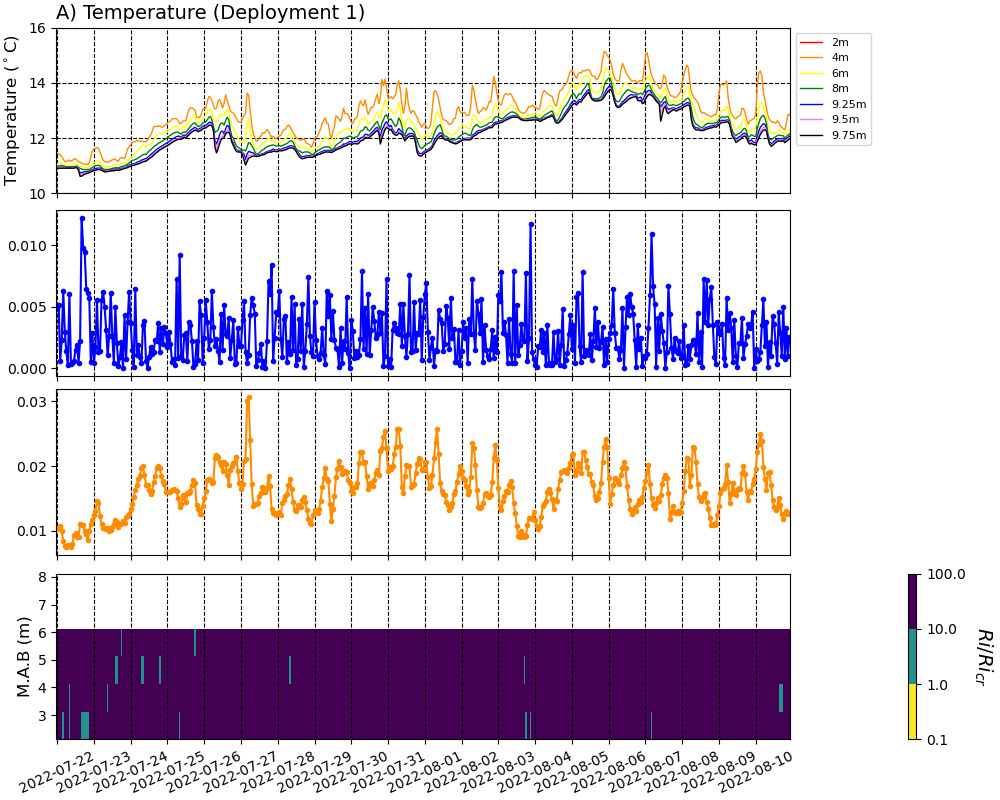

In [394]:
import matplotlib.dates as mdates

rSamp = '60Min'
RiDS = RiDS1.copy(deep=True)
Temp = temp.Temperature.sel(time=slice(RiDS.time[0],RiDS.time[-1])).resample(time=rSamp).mean()

fig,axs=plt.subplots(4,1,constrained_layout=True,sharex=True,figsize=(10,8))

axs[0].set_title('A) Temperature (Deployment 1)', loc='left', size=14) 
axs[0].set_prop_cycle(c = ['red','darkorange','yellow','green','blue','violet','black'])
axs[0].plot(Temp.time, Temp.T, lw = 1)
axs[0].set_ylabel(r'Temperature ($^\circ$C)', fontsize=12)
axs[0].margins(x=.01)
axs[0].set_ylim(10,16)
axs[0].grid(ls='--',color='black',axis='both',which='both')
axs[0].legend(temp.attrs['Depths from surface'], bbox_to_anchor=(1.00, 1), loc="upper left", fancybox=True, fontsize=8)

axs[1].plot(RiDS.time[:-2],np.sqrt(RiDS.S2[1][:-2]),'.-b')
#axs[1].plot(E.time[:-2],np.sqrt(S2[5][:-2]),'-r')
axs[1].grid(axis='x',ls='--',c='black')

axs[2].plot(RiDS.time[:-2],np.sqrt(RiDS.N2[1][:-2]),'.-',c='darkorange')
axs[2].grid(axis='x',ls='--',c='black')

bounds = np.array([.1, 1, 10, 100])
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#axs.set_title('Gradient Richardson Number')
RiPlot = axs[3].pcolormesh(RiDS.time[:-2], RiDS.bindistInterp[1:29].values, RiDS.Ri_g[1:29,:-2]/.25, norm = norm, cmap = 'viridis_r', shading = 'nearest')
axs[3].set_ylabel('M.A.B (m)', fontsize = 12)
axs[3].yaxis.set_major_locator(ticker.FixedLocator(np.arange(0,9,1)))
axs[3].tick_params(axis = 'x', labelrotation = 25)
#ax.set_ylim(1,8)
#ax.margins(x=.01)
fig.colorbar(RiPlot, location='right').set_label(label=r"$Ri/Ri_{cr}$",size=14,rotation = -90, va = 'bottom')
axs[3].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axs[3].grid(axis='x',ls='--',c='black')

In [179]:
RiDS1

<xarray.Dataset>
Dimensions:        (bindist: 47, bindistInterp: 7, time: 1441, time_raw: 28801)
Coordinates:
  * bindist        (bindist) float64 1.25 1.5 1.75 2.0 ... 12.0 12.25 12.5 12.75
  * bindistInterp  (bindistInterp) float64 1.625 2.625 3.625 ... 6.625 7.625
  * time           (time) datetime64[ns] 2022-07-22 ... 2022-08-11
  * time_raw       (time_raw) datetime64[ns] 2022-07-22 ... 2022-08-11
Data variables:
    U_raw          (bindist, time_raw) float64 0.001 0.0 0.023 ... nan nan nan
    V_raw          (bindist, time_raw) float64 -0.001 -0.024 -0.036 ... nan nan
    U              (bindistInterp, time) float64 -0.005237 -0.003988 ... 0.00825
    V              (bindistInterp, time) float64 -0.005237 -0.003988 ... 0.00825
    Rho            (bindistInterp, time) float64 1.026e+03 1.026e+03 ... nan nan
    RhoBar         (time) float64 1.026e+03 1.026e+03 ... 1.025e+03 1.025e+03
    dRho           (bindistInterp, time) float64 -0.03554 -0.03741 ... nan nan
    N2             (bindistInterp, time) float64 0.0003399 0.0003578 ... nan nan
    S2             (bindistInterp, time) float64 nan nan ... 0.001361 0.01378
    Ri_g           (bindistInterp, time) float64 nan nan nan nan ... nan nan nan
Attributes:
    Desciption:        Gradient Richardson number and the variables involved ...
    Sample frequency:  20Min
    Bin size (m):      0.25

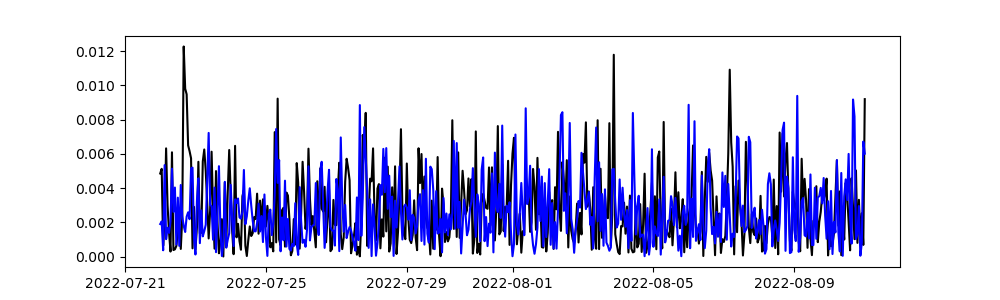

In [392]:
S = np.sqrt(RiDS1.S2.dropna(dim='time',how='all'))
plt.figure(figsize=(10,3))
plt.plot(S.time,S[1],'-k')
plt.plot(S.time,S[2],'-b')
#plt.plot(S.time,S[10],'-g',lw=1)

In [150]:
def RGN_plot(RiDS,coarsen=None,binStart=None,binEnd=None,resample=None,binDist=0):

    Ri = RiDS.Ri_g.dropna(dim='time',how='all')
    N2 = RiDS.N2.dropna(dim='time',how='all')
    S2 = RiDS.S2.dropna(dim='time',how='all')
    S_roll = np.sqrt(S2).rolling(time=6).mean()
    Rho = RiDS.Rho
    if coarsen:
        Ri = Ri.sel(bindist=slice(binStart,binEnd))
        Ri = Ri.coarsen(bindist=coarsen).mean()
        
        N2 = N2.sel(bindist=slice(binStart,binEnd))
        N2 = N2.coarsen(bindist=coarsen).mean()
        
        S2 = S2.sel(bindist=slice(binStart,binEnd))
        S2 = S2.coarsen(bindist=coarsen).mean()
        
        Rho = Rho.sel(bindist=slice(binStart,binEnd))
        Rho = Rho.coarsen(bindist=coarsen).mean()
    if resample:
        Ri = Ri.resample(time=resample).mean()
        N2 = N2.resample(time=resample).mean()
        S2 = S2.resample(time=resample).mean()
        Rho = Rho.resample(time=resample).mean()
        
    fig, ax = plt.subplots(4, 1, constrained_layout=True, sharex = True, figsize=(12,8))

    ax[0].set_title('Density')
    RhoPlot = ax[0].pcolormesh(Rho.time, Rho.bindistInterp, Rho, cmap = 'gist_rainbow', shading = 'nearest')
    ax[0].set_ylabel('M.A.B (m)', fontsize = 12)
    ax[0].tick_params(axis = 'x', labelrotation = 15)
    ax[0].set_ylim(1,8)
    ax[0].margins(x=.01)
    fig.colorbar(RhoPlot, location='right').set_label(label=r"$\frac{kg}{m^{3}}$",size=14,rotation = -90, va = 'bottom')

    ax[1].set_title('Brunt-Väisälä Frequency')
    ax[1].plot(N2.time, np.sqrt(N2[binDist]), '-k')
    ax[1].set_ylabel(r'$N$ ($\frac{1}{s}$)')
    ax[1].tick_params(axis = 'x', labelrotation = 15)
    ax[1].margins(x=.01)
    
    ax[2].set_title('Shear')
    ax[2].plot(S2.time, np.sqrt(S2[binDist]), '-k')
    ax[2].plot(S_roll.time, S_roll[binDist], '-',c='orange')
    ax[2].set_ylabel(r'$S$ ($\frac{1}{s}$)')
    ax[2].tick_params(axis = 'x', labelrotation = 15)
    ax[2].margins(x=.01)
    
    bounds = np.array([.1, 1, 10, 100])
    norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    ax[3].set_title('Gradient Richardson Number')
    RiPlot = ax[3].pcolormesh(Ri.time, Ri.bindistInterp, Ri/.25, norm = norm, cmap = 'Greys_r', shading = 'nearest')
    ax[3].set_ylabel('M.A.B (m)', fontsize = 12)
    ax[3].tick_params(axis = 'x', labelrotation = 15)
    ax[3].set_ylim(1,8)
    ax[3].margins(x=.01)
    fig.colorbar(RiPlot, location='right').set_label(label=r"$Ri/Ri_{cr}$",size=14,rotation = -90, va = 'bottom')

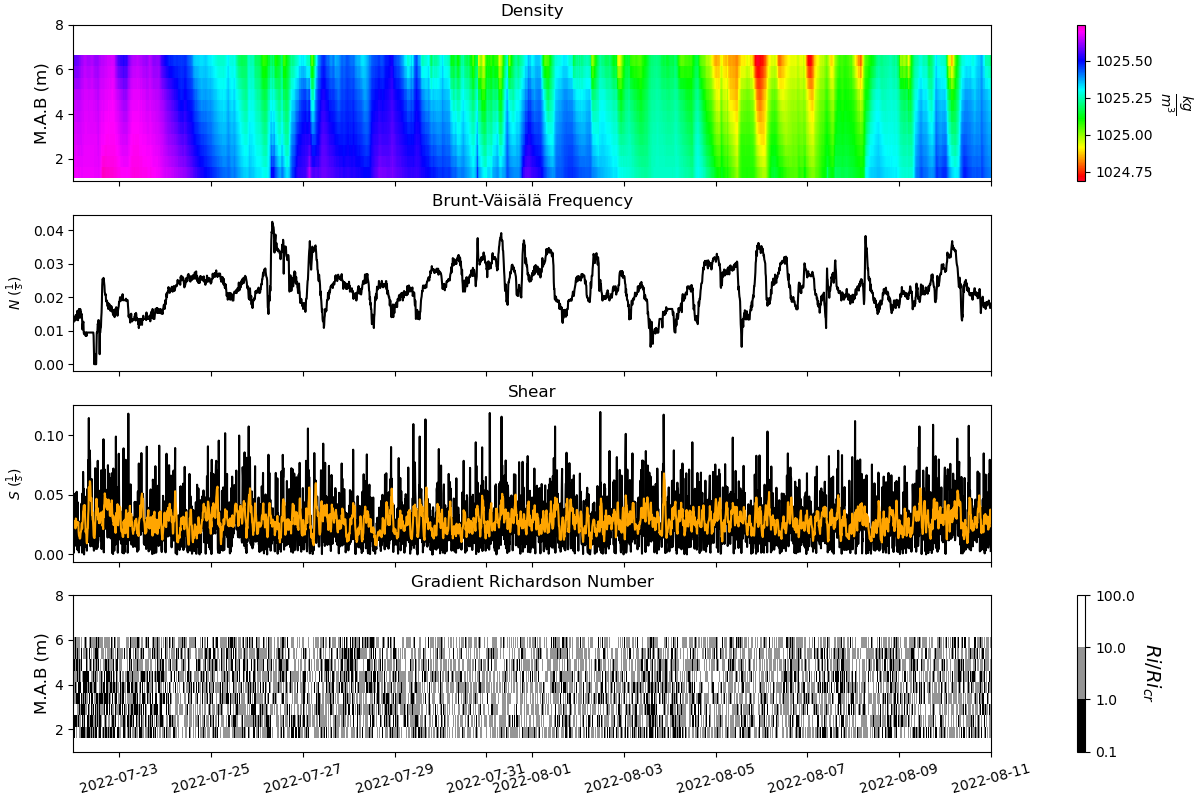

In [151]:
RGN_plot(RiDS1,coarsen=None,binStart=None,binEnd=None,resample=None,binDist=1)
#plt.savefig('Figures/Ri_dep1.png')

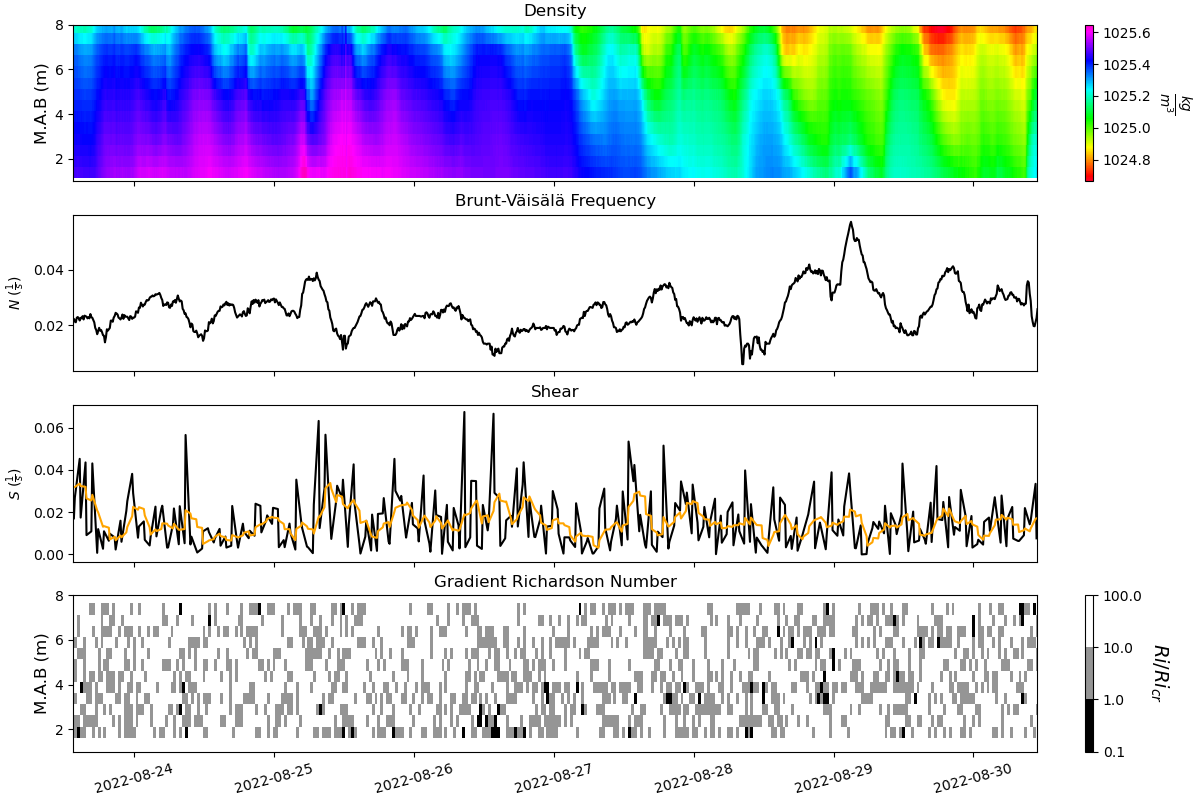

In [152]:
RGN_plot(RiDS2,coarsen=None,binStart=0,binEnd=8,resample=None,binDist=1)
#plt.savefig('Figures/Ri_dep2.png')

In [168]:
#Minimum N2 required to achieve critical Ri
critN2 = RiDS1.Ri_g * RiDS1.S2.dropna(dim='time',how='all')
N2ratio = (critN2-RiDS1.N2)/critN2

critS2 = RiDS1.Ri_g * RiDS1.N2.dropna(dim='time',how='all')
S2ratio = (RiDS1.S2-critS2)/critS2

In [169]:
S2ratio

<xarray.DataArray (bindistInterp: 14, time: 2881)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.45197770e+02, -9.99875029e-01,  2.35465034e+00, ...,
         3.22749686e+00,  3.18101024e+00, -9.99397266e-01],
       [ 2.79663505e+00,  1.70768013e+00,  3.83313327e+02, ...,
        -7.33719323e-01, -3.58048441e-02,  5.99272145e+01],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])
Coordinates:
  * bindistInterp  (bindistInterp) float64 1.375 1.875 2.375 ... 7.375 7.875
  * time           (time) datetime64[ns] 2022-07-22 ... 2022-08-11

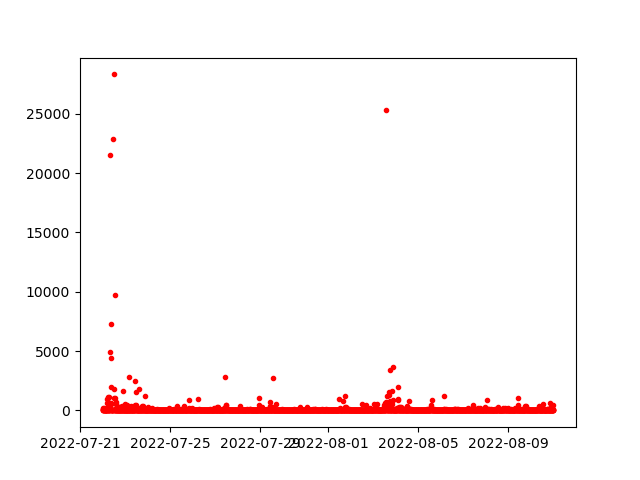

In [172]:
plt.figure()
#plt.plot(RiDS1.time,N2ratio[1],'.k')
plt.plot(RiDS1.time,S2ratio[1],'.r')

# RiDS1.to_netcdf('Dissipation/RiDS1_final.nc')
RiDS2.to_netcdf('Dissipation/RiDS2_final.nc')

In [3]:
RiDS1 = xr.open_dataset('Dissipation/RiDS1_final.nc')
RiDS2 = xr.open_dataset('Dissipation/RiDS2_final.nc')